# **User Data Score -- Ongo **


______________________________________________________________________________________________________________________
## In this document we want to assign a score to users, indicating the overall quality of their data. 

### We define a user's data quality score to be a number 1-100 reflecting a combination of recency, consistency, and quantity/correlation strength, indicating how strong the correlations and conclusions we can make from one's data are. The higher a user's score, the more confident we are of creating strong recommendations.


- Recency is defined by how recent the bulk of a user's data is. ideally user's have recent data, leading to more relevant conclusions
- Consistency is defined by how much consistently a user is collecting their data, an ideal user would upload data on a consistent basis, making patterns more clear
- Quantity/correlation strength is how many point of data a user owns of each type and how strong of patterns we are currently finding. This helps us deal with variance of data, and confirm the strength of our variable relationships. 

______________________________________________________________________________________________________________________




# Process

### To start we will partition the score into 1/8 recency, 1/8 consistency, and 3/4 quantity/correlation. 
### *We will focus on the type variables steps, weight, sleep, HR

Note: This splitting is arbitrary in nature and will be changed as we test our score. 

#### *This next cell just initializes our environment.* 

In [20]:
import seaborn as sns
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import linear_model
import itertools
import calendar
%matplotlib inline
sns.set()
import datetime
import warnings

data_sample = pd.read_csv('20171016-210106-DataSample.csv',dtype={"value": float})
data_sample2 = pd.read_csv('20171016-210304-DataSample.csv',dtype={"value": float})
data_sample3 = pd.read_csv('20171016-210529-DataSample.csv',dtype={"value": float})
data_sample4 = pd.read_csv('20171031-235959-DataSample.csv',dtype={"value": float})



data_sample = data_sample.append([data_sample2,data_sample3,data_sample4])
data_sample['startDate'] = pd.to_datetime(data_sample['startDate']) 
data_sample['owner'].replace('00000000-5854-8d6f-b8eb-cf14a0f795df','00000000-56ff-538b-2223-e1800b5e3ddb',inplace=True)
data_sample['startDate'] = pd.to_datetime(data_sample['startDate'])
data_sample['endDate'] = pd.to_datetime(data_sample['endDate'])
data_sample.index = data_sample['startDate']

to_tdelta = lambda row: row['endDate'] - row['startDate']
data_sample['duration'] = data_sample.apply(to_tdelta, axis=1)
data_sample['day_of_week'] = data_sample['startDate'].dt.dayofweek


## Recency

### Method: We want to see whether or not a user's data is recent or not. We will take the total amount of a user's data, see when the data was initially tracked, and see how much of that data exists within the last 60 days. 

Example: User X has 100 points of data for sleep over 2 years of collected data. However 99% of this data was before the past 60 days. This is bad. 

### Aydin, Luqmaan -> Calculate a score out of a 100. A 100 for a type would be a user who's data in the past 60 days is equal to or greater than 60 days / total time interval data has been collected. 

## Formula: (x/y) * (z/60) = type recency score  

### x -> amount of data in last 60 days 
### y -> total amount of data 
### z -> total days that their data was collected

## After doing this for each type you will have a few scores, average them for a final score


Example: User has 100 points of data over past 120 days, 50 points of data are in past 60 days. Score of 100. 

## Consistency

### Method: We want to see how consistent the collection of a user's data is. For variables that we want to compare on certain intervals, we want to know how much data we're "losing". 

Example: User X has 1000 points of HR, and 500 points of step count, however, on a very large number of days where he measured his step counts, he didn't measure his heart rate. Or on those days he did not record his amount of sleep. This data is essentially difficult to use, as this could have profound effects on the correlations we find. 

### Matt -> Calculate out a score 0-100 grading the consistency of a user's data. 
#### Do this for each type, and average them out. 
#### Note the different types of variables will have varying intervals of time, so for weight you wouldn't really care if they measure every day, but if you had a month's worth of user activity, but no weight measurement's during that time, that is bad. Or if all 4 of their weight measurements were in the last 2 weeks out of 4 months.

#### There's a lot of freedom on this, let me know if you have any questions or anything


## Quantity/Correlation Strength 

### Method: We essentially want to see if this user's data is telling us anything. Can we find correlations, patterns in the data, and how confident can we be in those correlations. We look into the different combinations of the variables, see how many we can find strong results

Example: User X has stellar correlations, we find strong patterns in all the variable combinations, small p-values for each of them, high score. 

### Lucas, Sebastian, John -> We want to look at what the chance is that the correlations that we are finding are "random" or not. We can use p-values across the different combinations, see how many we can be fairly confident in, and create a score from that. 

In [ ]:
Correlations to make 
- HR by Steps
- Steps by Sleep 
- Weight by Steps
- Weight by Sleep 
- HR by Sleep 

In [14]:
def prepare_table(x, y,time='D',data_sample=data_sample):
    steps = data_sample[data_sample['type'] == x]
    bodyfat = data_sample[data_sample['type'] == y]


    steps.index = steps['startDate']
    bodyfat.index = bodyfat['startDate']


    steps['value'] = pd.to_numeric(steps['value'])
    steps = steps.loc[:,'value']
    if x == 'health-step-count':
        steps = steps.resample(time).sum()
    else:
        steps = steps.resample(time).mean()


    bodyfat['value'] = pd.to_numeric(bodyfat['value'])
    bodyfat = bodyfat.loc[:,'value']
    bodyfat = bodyfat.resample(time).mean()

    steps = steps.to_frame('first')
    steps['second'] = bodyfat
    
    return steps

In [15]:
def plotter(steps):
    steps = steps.dropna()
    x = steps['first'].values
    y = steps['second'].values
    x = x.reshape(len(x), 1)
    y = y.reshape(len(x), 1)
    if not (x.shape == (0, 1) or y.shape == (0, 1)):
        regr = linear_model.LinearRegression()
        regr.fit(x, y)

        # plot it as in the example at http://scikit-learn.org/
        plt.scatter(x, y,  color='black')
        plt.plot(x, regr.predict(x), color='yellow', linewidth=2)

        corr_info = stats.stats.pearsonr(x, y)
        r = corr_info[0][0]
        if corr_info[1] == 0.0:
            p = corr_info[1]
        else:
            p = corr_info[1][0]
        return r, p
    else:
        return -5, -5

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


For Owner 00000000-56ff-538b-2223-e1800b5e3ddb: r is 0.234298508068 and p 0.0509081382523


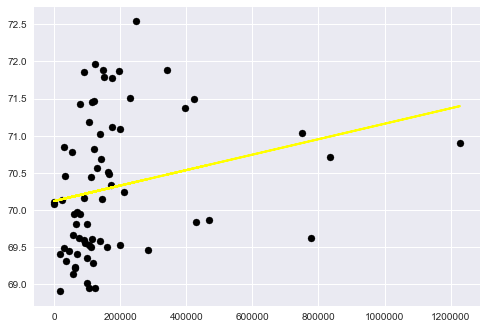

For Owner 00000000-5851-ee08-eb34-e20acc5af74e: r is 0.566027743159 and p 0.0074792955221


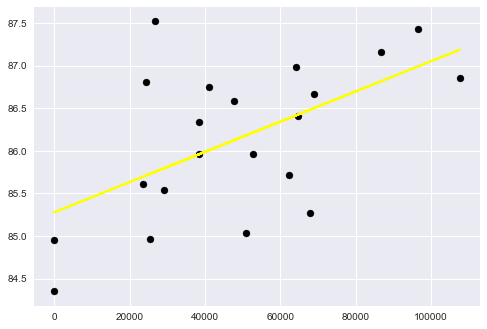

For Owner d145b032-b7a5-4fa8-9887-b46598f4683a: r is nan and p nan


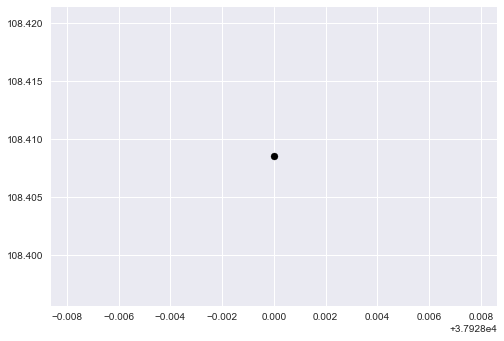

For Owner00000000-5951-4787-2497-ae32dc8d07d4: Not enough data points
For Owner 00000000-584d-a4f0-bdee-d4102b989ce5: r is 0.214218635229 and p 0.683587253434


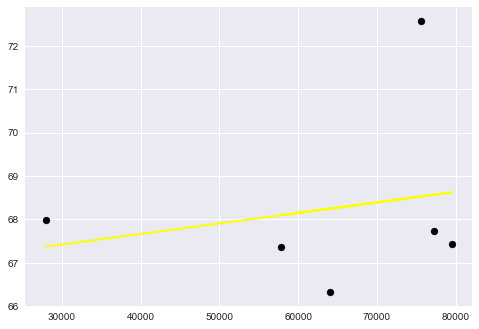

For Owner00000000-584e-1f39-bdee-d4102b989d01: Not enough data points


In [26]:
for owner in data_sample['owner'].unique():
    frame1 = prepare_table("health-step-count", "health-weight", 'W', data_sample[data_sample['owner'] == owner])
    r, p = plotter(frame1)
    if r != -5:
        print("For Owner {}: r is {} and p {}".format(owner, r, p))
    else:
        print("For Owner{}: Not enough data points".format(owner))
    plt.show()
    

## Testing 

### After creating our score we will want to be able test how accurate they are. 
### TO BE CONTINUED